In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
import nltk
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

In [2]:
file_path = "data exploration/explored_data.csv"  
data = pd.read_csv(file_path)

print(data.head())

        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review  Rating  \
0  The ambience was good, food was quite good . h...     5.0   
1  Ambience is too good for a pleasant evening. S...     5.0   
2  A must try.. great food great ambience. Thnx f...     5.0   
3  Soumen das and Arun was a great guy. Only beca...     5.0   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0   

                  Time  Pictures  Review_Count  Follower_Count  Review_Length  
0  2019-05-25 15:54:00         0           1.0             2.0            222  
1  2019-05-25 14:20:00         0           3.0             2.0            144  
2  2019-05-24 22:54:00         0           2.0             3.0            189  
3  2019-05-24 22:11:00        

In [3]:
print(data['Review'].isnull().sum())
print(data['Rating'].isnull().sum())

45
0


In [4]:
data['Review'] = data['Review'].fillna("")

In [5]:
count = CountVectorizer()
porter = PorterStemmer()

In [6]:
three_star_reviews = data[data['Rating'] == 3]  # Select only 3-star reviews
print(three_star_reviews.head())

# for review in three_star_reviews['Review']:
#     print("\n" + "-"*50)  # Separator for clarity
#     print(review)

         Restaurant               Reviewer  \
30  Beyond Flavours           Pragya Sarda   
45  Beyond Flavours                Sind Hu   
56  Beyond Flavours            Dyagamrahul   
73  Beyond Flavours  Saswati Kar Choudhury   
76  Beyond Flavours     Susmitha Penisetti   

                                               Review  Rating  \
30  Short review: Decent breads and starters, bad ...     3.0   
45  The reason for giving only a 3 star is because...     3.0   
56  We went for lunch buffet yesterday and took a ...     3.0   
73  We happened to go to this place on last sunday...     3.0   
76  I have been to this place twice and had 2 diff...     3.0   

                   Time  Pictures  Review_Count  Follower_Count  Review_Length  
30  2019-05-20 00:35:00         0           9.0             8.0           1169  
45  2019-05-18 14:16:00         0          61.0           167.0            399  
56  2019-05-16 07:13:00         0          25.0            24.0            895  
73  2019

In [7]:
# data['Sentiment'] = (data['Rating'] >= 3).astype(int)
data['Review'].fillna("No review", inplace=True)  
data['Review'] = data['Review'].replace("", "No review")  

data.loc[data["Rating"] >= 4, "Sentiment"] = 1
data.loc[data["Rating"] <= 2, "Sentiment"] = 0

labeled_data = data[data['Rating'] != 3]
X_train = labeled_data['Review']
y_train = (labeled_data['Rating'] >= 4).astype(int)  # 1 = Positive, 0 = Negative

# Train SVM Classifier
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', SVC()) 
])
pipeline.fit(X_train, y_train)

# Predict sentiment for 3-star reviews
data.loc[data['Rating'] == 3, 'Sentiment'] = pipeline.predict(data[data['Rating'] == 3]['Review'])

In [8]:
print(data["Sentiment"].isnull().sum())

66


In [23]:
data["Sentiment"].fillna(0, inplace=True) 
print(data["Sentiment"].isnull().sum())

0


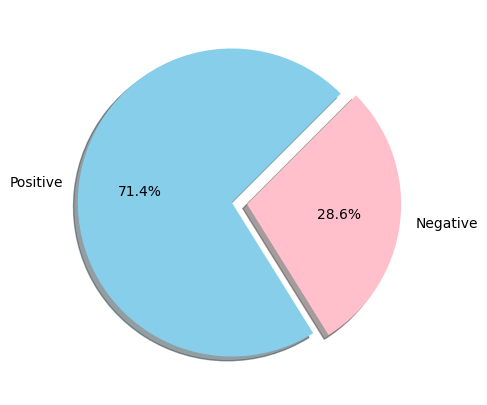

In [24]:
fig=plt.figure(figsize=(5,5))
# Define colors for the pie chart segments
colors=["skyblue",'pink']
# Filter data to separate positive and negative labels
pos=data[data['Sentiment']==1]
neg=data[data['Sentiment']==0]
# Count the number of positive and negative instances
ck=[pos['Sentiment'].count(),neg['Sentiment'].count()]
# Create a pie chart with the counts of positive and negative instances
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%',
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [25]:
# Select 3-star reviews along with their predicted sentiment
three_star_reviews = data[data['Rating'] == 3][['Review', 'Sentiment']]

print(three_star_reviews.head())

# # Display the reviews with their predicted sentiment
# for index, row in three_star_reviews.iterrows():
#     print("\n" + "-"*80)  # Separator for clarity
#     print(f"Review: {row['Review']}")
#     print(f"Predicted Sentiment: {'Positive' if row['Sentiment'] == 1 else 'Negative'}")


                                               Review  Sentiment
30  Short review: Decent breads and starters, bad ...        0.0
45  The reason for giving only a 3 star is because...        0.0
56  We went for lunch buffet yesterday and took a ...        0.0
73  We happened to go to this place on last sunday...        1.0
76  I have been to this place twice and had 2 diff...        1.0


In [26]:
nltk.download('stopwords') 
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


False

Positive words are as follows


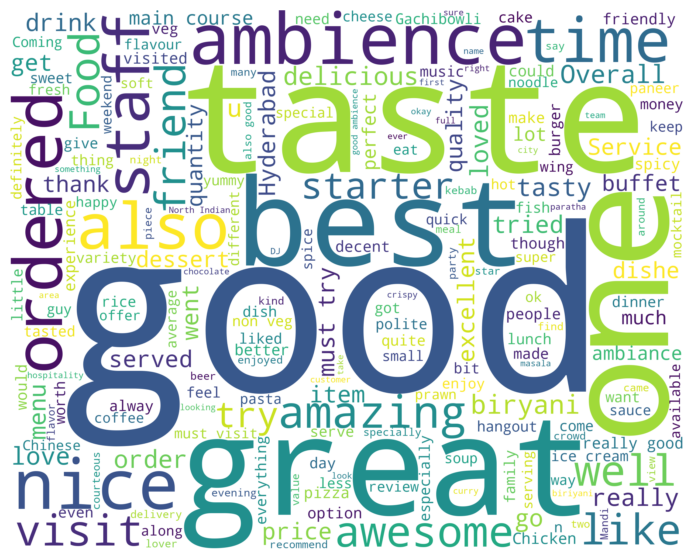

Negative words are as follows


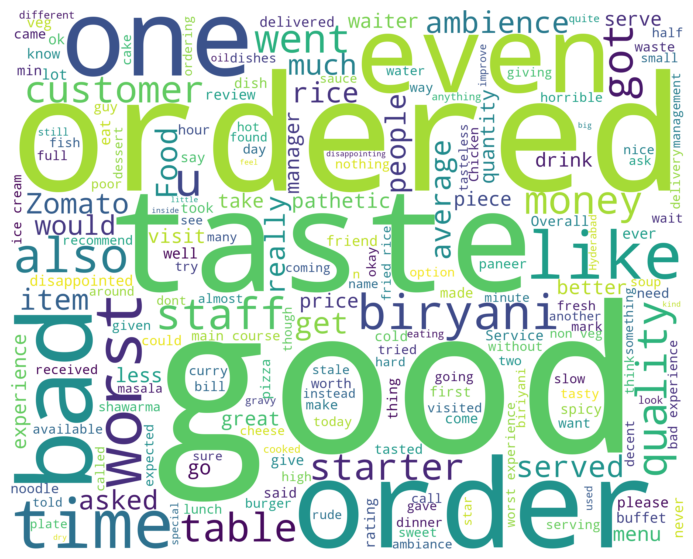

In [27]:
positivedata = data[data['Sentiment'] == 1]['Review']
negdata = data[data['Sentiment'] == 0]['Review']
stop = set(stopwords.words('english'))

def wordcloud_draw(data, color='white'):
    words = ' '.join(data)
    words = re.sub(r'(?:restaurant|food|place|service|chicken)', '', words)  # Removing common words
    cleaned_words = " ".join([word for word in words.split()])
    
    wordcloud = WordCloud(stopwords=stop,
                          background_color=color,
                          width=2500,
                          height=2000).generate(cleaned_words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

print("Positive words are as follows")
wordcloud_draw(positivedata, 'white')

print("Negative words are as follows")
wordcloud_draw(negdata)

In [28]:
def preprocess_text(text):
  text = re.sub(r'\d+', '', text)  # remove numbers 
  text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
  emojis = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)  # find emojis
  # remove non-word characters and add the emojis
  text = re.sub(r'\W+', ' ', text) + " " + " ".join(emojis).replace('-', '')  
  return text.strip()

In [29]:
first_review = data["Review"].iloc[0]
print(first_review)
processed_review = preprocess_text(first_review)
print(processed_review)

The ambience was good, food was quite good . had Saturday lunch , which was cost effective .
Good place for a sate brunch. One can also chill with friends and or parents.
Waiter Soumen Das was really courteous and helpful.
The ambience was good food was quite good had Saturday lunch which was cost effective Good place for a sate brunch One can also chill with friends and or parents Waiter Soumen Das was really courteous and helpful


In [30]:
def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

In [31]:
nltk.download('stopwords')
stop=stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


In [32]:
tfidf = TfidfVectorizer(
    strip_accents=None,
    lowercase=True,
    stop_words=stop,
    preprocessor=preprocess_text,
    tokenizer=tokenizer_porter,
    use_idf=True,
    norm='l2',
    smooth_idf=True
)

In [33]:
print((data["Rating"] == 3).sum())  # Check how many 3-star reviews exist
print(data[data["Rating"] == 3]["Sentiment"].isnull().sum())

1193
0


In [34]:
y = data.Sentiment.values

# applying td-idf
x = tfidf.fit_transform(data.Review)

/Users/yty/Library/Python/3.10/lib/python/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/yty/Library/Python/3.10/lib/python/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'ha', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hi', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shed', 'shell', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'theyd', 'theyll', 'theyr', 'theyv', 'thi', 'veri', 'wa', 'wasnt', 'wed', 'well', 'werent', 'weve', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  warnings.warn(


In [35]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.5, shuffle=False)

In [36]:
print(np.isnan(y_train).sum())

0


In [37]:
# Train Logistic Regression with SGD
clf_log = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True)
clf_log.fit(X_train, y_train)
y_pred_log = clf_log.predict(X_test)
print("Logistic Loss Accuracy:", metrics.accuracy_score(y_test, y_pred_log))

Logistic Loss Accuracy: 0.8858


In [38]:
# Train Linear SVM with SGD, hinge loss
clf_svm = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, class_weight='balanced')
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print("SVM Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.8834


In [39]:
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))

print("SVM Report:")
print(classification_report(y_test, y_pred_svm))

Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79      1481
         1.0       0.89      0.96      0.92      3519

    accuracy                           0.89      5000
   macro avg       0.88      0.84      0.86      5000
weighted avg       0.88      0.89      0.88      5000

SVM Report:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80      1481
         1.0       0.92      0.92      0.92      3519

    accuracy                           0.88      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.88      0.88      0.88      5000



In [40]:
# average sentiment score per restaurant
sentiment_scores = data.groupby("Restaurant")["Sentiment"].mean().reset_index()
sentiment_scores.rename(columns={"Sentiment": "Sentiment_Score"}, inplace=True)
print(sentiment_scores.head())

sentiment_scores.to_csv("sentiment_scores.csv", index=False)

                       Restaurant  Sentiment_Score
0               10 Downing Street             0.86
1                        13 Dhaba             0.67
2  3B's - Buddies, Bar & Barbecue             0.94
3       AB's - Absolute Barbecues             0.98
4               Absolute Sizzlers             0.68
